<a href="https://colab.research.google.com/github/Sumyeong-Kim/Kream-project/blob/main/pokemon_project_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# 필요한 패키지 설치
!pip install torch torchvision pandas scikit-learn

In [79]:
# /content 디렉토리에 있는 파일 확인
!ls /content

 ex   ex2  'pokemon 2.zip'   Pokemon3   pokemon3.zip   pokemon.zip   sample_data


In [88]:
# /content 디렉토리의 파일 목록 확인
!ls /content

# /content/sample_data 디렉토리의 파일 목록 확인
!ls /content/sample_data

 ex   ex2  'pokemon 2.zip'   Pokemon3   pokemon3.zip   pokemon.zip   sample_data
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [90]:
# pokemon.zip 파일 압축 해제
!unzip -o /content/pokemon3.zip -d /content/Pokemon

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff52.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff52.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff2.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff2.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff44.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff44.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff50.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff50.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff51.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff51.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuff45.jpg  
  inflating: /content/Pokemon/__MACOSX/pokemon 2/Wigglytuff/._wigglytuff45.jpg  
  inflating: /content/Pokemon/pokemon 2/Wigglytuff/wigglytuf

In [91]:
# 압축 해제된 파일 확인
!ls /content/Pokemon3

 __MACOSX   poke_data.csv   poke_data_path.csv	 pokemon  'pokemon 2'


In [92]:
# __MACOSX 폴더 삭제
!rm -rf /content/Pokemon3/__MACOSX

In [105]:
import os
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# 데이터 전처리(요소 추가)

In [145]:
# CSV 파일 읽기
file_path = 'Pokemon3/poke_data.csv'
df = pd.read_csv(file_path)

# 1. Type1, Type2 데이터 변경
type_mapping = {
    'Bug': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6,
    'Ghost': 7, 'Grass': 8, 'Ground': 9, 'Ice': 10, 'Normal': 11, 'Poison': 12,
    'Psychic': 13, 'Rock': 14, 'Water': 15
}

# Type1과 Type2 컬럼에 대해 매핑 적용
df['Type 1'] = df['Type 1'].map(type_mapping)
df['Type 2'] = df['Type 2'].map(type_mapping)

# 2. Legendary 값을 0과 1로 변환
df['Legendary'] = df['Legendary'].map({False: 0, True: 1})

# 3. 능력치 평균에 따른 새로운 컬럼 추가
stats_columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

for col in stats_columns:
    avg_value = df[col].mean()  # 해당 컬럼의 평균 계산
    new_col_name = f'{col}_Above_Average'
    df[new_col_name] = (df[col] > avg_value).astype(int)  # 평균보다 높으면 1, 낮으면 0

# 4. 수정된 CSV 파일 저장
new_file_path = 'Pokemon3/poke_data_path.csv'  # 새로운 CSV 파일 경로
df.to_csv(new_file_path, index=False)

# 데이터 확인
df.head(2)

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Koreaname,Total_Above_Average,HP_Above_Average,Attack_Above_Average,Defense_Above_Average,Sp. Atk_Above_Average,Sp. Def_Above_Average,Speed_Above_Average
0,Bulbasaur,8,12.0,318,45,49,49,65,65,45,1,0,이상해씨,0,0,0,0,0,0,0
1,Ivysaur,8,12.0,405,60,62,63,80,80,60,1,0,이상해풀,0,0,0,0,1,1,0


In [118]:
# 이미지 전처리 및 데이터 로드
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'Pokemon3/pokemon'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# CSV 파일 로드 및 전처리
csv_path = 'Pokemon3/poke_data_path.csv'
poke_data = pd.read_csv(csv_path)

label_encoder = LabelEncoder()
poke_data['Label'] = label_encoder.fit_transform(poke_data['Name'])

name_to_index = {name: idx for idx, name in enumerate(label_encoder.classes_)}
index_to_name = {idx: name for name, idx in name_to_index.items()}

# CNN 모델 학습 - 이미지 + 요소(타입만 빠짐)

In [135]:
# 이미지 전처리 및 데이터 로드
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'Pokemon3/pokemon'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# CSV 파일 로드 및 전처리
csv_path = 'Pokemon3/poke_data_path.csv'
poke_data = pd.read_csv(csv_path)

# 필요한 모든 추가 입력 데이터 생성
additional_features = poke_data[['Total', 'HP', 'Attack', 'Defense',
                                 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary',
                                 'Total_Above_Average', 'HP_Above_Average', 'Attack_Above_Average',
                                 'Defense_Above_Average', 'Sp. Atk_Above_Average',
                                 'Sp. Def_Above_Average', 'Speed_Above_Average']].values.astype('float32')

# Label encoding
label_encoder = LabelEncoder()
poke_data['Label'] = label_encoder.fit_transform(poke_data['Name'])

name_to_index = {name: idx for idx, name in enumerate(label_encoder.classes_)}
index_to_name = {idx: name for name, idx in name_to_index.items()}

# CNN 모델 정의 (모든 추가 입력을 받도록 확장)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, additional_input_dim):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 30 * 30 + additional_input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, additional_input):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the image feature vector

        x = torch.cat((x, additional_input), dim=1)  # 이미지와 추가 입력을 결합
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 초기화
num_classes = len(dataset.classes)
additional_input_dim = additional_features.shape[1]  # 추가 입력 데이터의 차원
model = SimpleCNN(num_classes=num_classes, additional_input_dim=additional_input_dim)

# 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        # 배치 크기 계산
        current_batch_size = images.size(0)

        # 이미지에 해당하는 추가 입력 데이터를 가져옵니다
        indices = labels.numpy()  # 현재 배치의 라벨에 해당하는 인덱스를 가져옵니다.
        batch_additional_inputs = torch.tensor(additional_features[indices])

        # 모델의 출력 계산
        outputs = model(images, batch_additional_inputs)

        # 손실 계산 및 역전파
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training completed.")

Epoch [1/10], Loss: 4.3603
Epoch [2/10], Loss: 2.5095
Epoch [3/10], Loss: 1.4504
Epoch [4/10], Loss: 0.8960
Epoch [5/10], Loss: 0.5797
Epoch [6/10], Loss: 0.3754
Epoch [7/10], Loss: 0.2424
Epoch [8/10], Loss: 0.1560
Epoch [9/10], Loss: 0.1045
Epoch [10/10], Loss: 0.0741
Training completed.


**결과해석 **
* 에포크가 진행될수록 손실 값이 지속적으로 감소하여 마지막 10번째 에포크에서는 손실 값이 0.0741로 매우 낮아졌습니다
* 이는 모델이 데이터를 매우 잘 학습했음을 의미


# 전체 반영(타입포함)한 추천시스템
* 3개의 포켓몬을 선택하고, 그에 대해 5개의 포켓몬을 추천함


Recommended Pokemon for ['Pikachu', 'Persian', 'Meowth']: ['Poliwag' 'Voltorb' 'Diglett' 'Rattata' 'Pidgeotto']


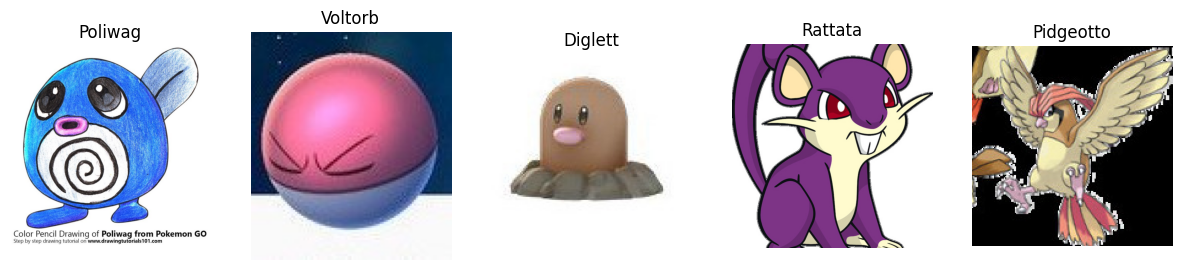

In [144]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image

# CSV 파일 로드 및 전처리
csv_path = 'Pokemon3/poke_data_path.csv'
poke_data = pd.read_csv(csv_path)

# 포켓몬 추천 시스템
def recommend_pokemon(selected_pokemon_names, poke_data, top_n=5):
    # 선택한 포켓몬들의 속성을 평균화
    selected_pokemons = poke_data[poke_data['Name'].isin(selected_pokemon_names)]
    selected_features = selected_pokemons[['Total', 'HP', 'Attack', 'Defense',
                                           'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary',
                                           'Total_Above_Average', 'HP_Above_Average', 'Attack_Above_Average',
                                           'Defense_Above_Average', 'Sp. Atk_Above_Average',
                                           'Sp. Def_Above_Average', 'Speed_Above_Average']].values

    # 선택한 포켓몬들의 속성 평균 계산
    mean_features = selected_features.mean(axis=0).reshape(1, -1)

    # 전체 포켓몬 속성과 유사도 계산
    features = poke_data[['Total', 'HP', 'Attack', 'Defense',
                          'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary',
                          'Total_Above_Average', 'HP_Above_Average', 'Attack_Above_Average',
                          'Defense_Above_Average', 'Sp. Atk_Above_Average',
                          'Sp. Def_Above_Average', 'Speed_Above_Average']].values

    # 표준화
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_mean_features = scaler.transform(mean_features)

    similarities = cosine_similarity(scaled_mean_features, scaled_features).flatten()

    # 유사도를 기반으로 추천 목록 생성
    poke_data['Similarity'] = similarities
    recommendations = poke_data.sort_values(by='Similarity', ascending=False).head(top_n + len(selected_pokemon_names))

    # 선택한 포켓몬들을 제외한 추천 포켓몬 반환
    recommended_pokemon = recommendations[~recommendations['Name'].isin(selected_pokemon_names)]['Name'].values[:top_n]
    return recommended_pokemon

# 포켓몬 이미지를 출력하는 함수
def display_pokemon_images(pokemon_names, image_folder):
    plt.figure(figsize=(15, 5))
    for i, name in enumerate(pokemon_names):
        # 폴더에서 포켓몬 이름을 포함하는 파일 검색
        img_path = None
        for root, dirs, files in os.walk(image_folder):
            for file in files:
                if name.lower() in file.lower():  # 파일 이름에 포켓몬 이름이 포함되어 있는지 확인 (대소문자 무시)
                    img_path = os.path.join(root, file)
                    break
            if img_path:
                break

        # 이미지가 발견되면 표시
        if img_path:
            img = Image.open(img_path)
            plt.subplot(1, len(pokemon_names), i + 1)
            plt.imshow(img)
            plt.title(name)
            plt.axis('off')
        else:
            print(f"Image for {name} not found.")
    plt.show()

# 여러 개의 포켓몬 선택
selected_pokemon_names = ['Pikachu', 'Persian', 'Meowth']
recommended_pokemon = recommend_pokemon(selected_pokemon_names, poke_data)
print(f"Recommended Pokemon for {selected_pokemon_names}: {recommended_pokemon}")

# 추천된 포켓몬 이미지 출력
image_folder = 'Pokemon3/pokemon'  # 포켓몬 이미지 폴더 경로
display_pokemon_images(recommended_pokemon, image_folder)

**CNN** 모델 학습 - 이미지만 학습함

In [58]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32 * 30 * 30)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(dataset.classes)
model = SimpleCNN(num_classes=num_classes)

# 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training completed.")


Epoch [1/10], Loss: 4.2058
Epoch [2/10], Loss: 2.3356
Epoch [3/10], Loss: 1.3018
Epoch [4/10], Loss: 0.5533
Epoch [5/10], Loss: 0.1925
Epoch [6/10], Loss: 0.0742
Epoch [7/10], Loss: 0.0405
Epoch [8/10], Loss: 0.0301
Epoch [9/10], Loss: 0.0256
Epoch [10/10], Loss: 0.0253
Training completed.


Recommended Pokemon for ['Pikachu', 'Persian', 'Meowth']: ['Poliwag' 'Aerodactyl' 'Electrode' 'Raticate' 'Dugtrio']


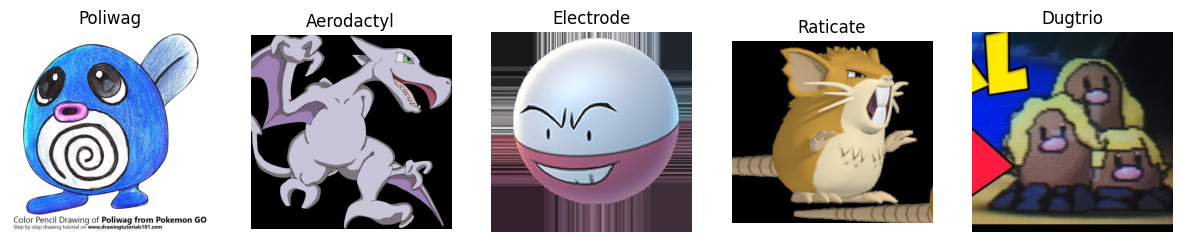

In [59]:
# 포켓몬 추천 시스템
def recommend_pokemon(selected_pokemon_names, poke_data, top_n=5):
    # 선택한 포켓몬들의 속성을 평균화
    selected_pokemons = poke_data[poke_data['Name'].isin(selected_pokemon_names)]
    selected_features = selected_pokemons[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].values

    # 선택한 포켓몬들의 속성 평균 계산
    mean_features = selected_features.mean(axis=0).reshape(1, -1)

    # 전체 포켓몬 속성과 유사도 계산
    features = poke_data[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].values
    similarities = cosine_similarity(mean_features, features).flatten()

    # 유사도를 기반으로 추천 목록 생성
    poke_data['Similarity'] = similarities
    recommendations = poke_data.sort_values(by='Similarity', ascending=False).head(top_n + len(selected_pokemon_names))

    # 선택한 포켓몬들을 제외한 추천 포켓몬 반환
    recommended_pokemon = recommendations[~recommendations['Name'].isin(selected_pokemon_names)]['Name'].values[:top_n]
    return recommended_pokemon

# 포켓몬 이미지를 출력하는 함수
def display_pokemon_images(pokemon_names, image_folder):
    plt.figure(figsize=(15, 5))
    for i, name in enumerate(pokemon_names):
        # 폴더에서 포켓몬 이름을 포함하는 파일 검색
        img_path = None
        for root, dirs, files in os.walk(image_folder):
            for file in files:
                if name.lower() in file.lower():  # 파일 이름에 포켓몬 이름이 포함되어 있는지 확인 (대소문자 무시)
                    img_path = os.path.join(root, file)
                    break
            if img_path:
                break

        # 이미지가 발견되면 표시
        if img_path:
            img = Image.open(img_path)
            plt.subplot(1, len(pokemon_names), i + 1)
            plt.imshow(img)
            plt.title(name)
            plt.axis('off')
        else:
            print(f"Image for {name} not found.")
    plt.show()

# 예시 데이터 및 이미지 폴더 설정
poke_data = pd.read_csv('Pokemon3/poke_data.csv')  # 포켓몬 데이터 로드
image_folder = 'Pokemon3/pokemon'  # 포켓몬 이미지 폴더 경로

# 여러 개의 포켓몬 선택
selected_pokemon_names = ['Pikachu', 'Persian', 'Meowth']
recommended_pokemon = recommend_pokemon(selected_pokemon_names, poke_data)
print(f"Recommended Pokemon for {selected_pokemon_names}: {recommended_pokemon}")

# 추천된 포켓몬 이미지 출력
display_pokemon_images(recommended_pokemon, image_folder)
